# Lambton County Census Data Analysis 

#  Part 1 - Data Acquisition and Municipal Boundary Processing

This section of the code handles the initial data collection and processing for Lambton County's census tract analysis.

### Dependencies
```python
import os
import requests
import zipfile
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import pandas as pd
```

### Main Functions

#### 1. `download_census_tracts()`
Downloads and extracts census tract boundaries from Statistics Canada.

**Functionality:**
- Creates a 'data' directory if it doesn't exist
- Downloads census tract data from Statistics Canada's website
- Shows download progress using tqdm
- Extracts the downloaded zip file
- Returns the path to the extracted shapefile

**Usage:**
```python
shapefile_path = download_census_tracts()
```

**Key Features:**
- Progress bar for download tracking
- Caching mechanism (won't re-download if file exists)
- Error handling for file operations

#### 2. `get_lambton_tracts(shapefile_path)`
Processes and filters census tract data specifically for Lambton County.

**Parameters:**
- Bounding Box Coordinates:
  - North: 43.3339
  - South: 42.5607
  - East: -81.8097
  - West: -82.5137

**Municipalities Covered:**
1. Brooke-Alvinston
2. Dawn-Euphemia
3. Enniskillen
4. Lambton Shores
5. Oil Springs
6. Petrolia
7. Plympton-Wyoming
8. Point Edward
9. Sarnia
10. St. Clair
11. Warwick

**Functionality:**
- Creates a bounding box for Lambton County
- Downloads municipal boundaries using OpenStreetMap data
- Processes each municipality's boundary data
- Generates a visualization of the municipal boundaries
- Adds required columns for census tract analysis

**Visualization Features:**
- Different colors for each municipality
- Labels with white backgrounds for visibility
- CartoDB Positron basemap
- Legend showing all municipalities
- Boundary box outline in red

**Output DataFrame Columns:**
- CTUID: Census tract identifier
- DGUID: Geographic identifier
- CTNAME: Municipality name
- LANDAREA: Area in square kilometers
- PRUID: Province identifier (35 for Ontario)

### Error Handling
- Handles missing municipality data gracefully
- Provides feedback for successful and failed boundary downloads
- Validates the presence of municipal boundaries before processing

### Visualization Details
The function creates a comprehensive map with:
- Municipal boundaries with unique colors
- Clear labels for each municipality
- Red outline showing the bounding box
- Base map from CartoDB for geographic context
- Proper legend placement
- Adjusted plot extent to focus on Lambton County

### Data Sources
- Census tract boundaries: Statistics Canada (2021 Census)
- Municipal boundaries: OpenStreetMap via OSMnx
- Base map: CartoDB Positron

In [1]:
import os
import requests
import zipfile
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
import pandas as pd
import numpy as np
import folium
from shapely.geometry import box, Point
import networkx as nx
from collections import Counter
from tqdm import tqdm
from IPython.display import display, HTML

# Use a proper style name
plt.style.use('seaborn-v0_8-white') 

def download_census_tracts():
    """
    Downloads and extracts Lambton County census tract boundaries.
    Returns the path to the extracted shapefile.
    """
    if not os.path.exists('data'):
        os.makedirs('data')
    print("\n1. DOWNLOADING CENSUS DATA")
    print("==========================")
    url = "https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/boundary-limites/files-fichiers/lct_000b21a_e.zip"
    zip_path = "data/census_tracts.zip"
    
    if not os.path.exists(zip_path):
        print("Downloading census tract boundaries...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        
        with open(zip_path, 'wb') as f:
            for data in tqdm(response.iter_content(block_size), 
                           total=total_size//block_size, 
                           unit='KB', 
                           desc="Download Progress"):
                f.write(data)
    
    print("Extracting files...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    print("✓ Census data downloaded and extracted\n")
    return 'data/lct_000b21a_e.shp'

def get_lambton_tracts(shapefile_path):
    """Load and filter Lambton County municipal boundaries"""
    print("\n2. PROCESSING MUNICIPAL BOUNDARIES")
    print("===========================")
    
    # Define the coordinates that encompass Lambton County
    lambton_bbox = {
        'north': 43.3339,  # Northernmost point
        'south': 42.5607,  # Southernmost point
        'east': -81.8097,  # Easternmost point
        'west': -82.5137   # Westernmost point
    }
    
    # Create a geodataframe with the boundary box
    bbox = box(lambton_bbox['west'], lambton_bbox['south'], 
               lambton_bbox['east'], lambton_bbox['north'])
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')
    
    # List of Lambton municipalities
    municipalities = [
        'Brooke-Alvinston',
        'Dawn-Euphemia',
        'Enniskillen',
        'Lambton Shores',
        'Oil Springs',
        'Petrolia',
        'Plympton-Wyoming',
        'Point Edward',
        'Sarnia',
        'St. Clair',
        'Warwick'
    ]
    
    print("Downloading municipal boundaries from OpenStreetMap...")
    
    # Create an empty list to store municipal boundaries
    municipal_boundaries = []
    
    # Download each municipality's boundary
    for municipality in municipalities:
        try:
            # Get the boundary using OSMnx
            boundary = ox.geocode_to_gdf(f"{municipality}, Lambton County, Ontario, Canada")
            if not boundary.empty:
                boundary['municipality'] = municipality
                municipal_boundaries.append(boundary)
                print(f"✓ Found boundary for {municipality}")
        except Exception as e:
            print(f"✗ Could not find boundary for {municipality}: {str(e)}")
    
    if not municipal_boundaries:
        raise ValueError("No municipal boundaries found")
    
    # Combine all boundaries
    lambton_gdf = pd.concat(municipal_boundaries, ignore_index=True)
    lambton_gdf = lambton_gdf.to_crs('EPSG:4326')
    
    # Plot the municipalities
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Plot the bounding box
    bbox_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2, alpha=0.5)
    
    # Plot each municipality with a different color and add labels
    for idx, municipality in enumerate(municipalities):
        mask = lambton_gdf['municipality'] == municipality
        if mask.any():
            # Get the municipality's geometry
            municipality_geom = lambton_gdf[mask].geometry.iloc[0]
            
            # Calculate centroid for label placement
            centroid = municipality_geom.centroid
            
            # Plot the municipality
            color = plt.cm.Set3(idx/len(municipalities))
            lambton_gdf[mask].plot(
                ax=ax,
                color=color,
                edgecolor='black',
                alpha=0.5,
                linewidth=1,
                label=municipality
            )
            
            # Add label with white background for better visibility
            ax.annotate(
                municipality,
                xy=(centroid.x, centroid.y),
                xytext=(0, 0),
                textcoords='offset points',
                ha='center',
                va='center',
                fontsize=8,
                fontweight='bold',
                bbox=dict(
                    boxstyle='round,pad=0.5',
                    fc='white',
                    ec='none',
                    alpha=0.7
                )
            )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=10)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_title('Municipalities in Lambton County', pad=20)
    ax.set_axis_off()
    
    # Adjust plot extent to Lambton County bbox
    ax.set_xlim(lambton_bbox['west'] - 0.1, lambton_bbox['east'] + 0.1)
    ax.set_ylim(lambton_bbox['south'] - 0.1, lambton_bbox['north'] + 0.1)
    
    plt.tight_layout()
    plt.show()
    
    # Add required columns to match the expected format
    lambton_gdf['CTUID'] = lambton_gdf.index.astype(str)
    lambton_gdf['DGUID'] = lambton_gdf['CTUID']
    lambton_gdf['CTNAME'] = lambton_gdf['municipality']
    lambton_gdf['LANDAREA'] = lambton_gdf.geometry.area / 1e6  # Convert to square km
    lambton_gdf['PRUID'] = '35'  # Ontario
    
    return lambton_gdf

# Part 2 -  Amenity Analysis and Feature Processing

This section documents the functions that analyze amenities, points of interest (POIs), and street networks within Lambton County census tracts.

### Function: `get_amenities_and_pois()`

Retrieves and processes amenities and POIs within a specified polygon.

**Parameters:**
- `polygon`: Geographic polygon area to analyze
- `tags`: OSM tags to filter amenities
- `category_name`: Category identifier for the amenities
- `tract_id`: Census tract identifier

**Process Flow:**
1. Converts input polygon to GeoDataFrame if needed
2. Fetches features using OSMnx
3. Processes each amenity's location and attributes
4. Generates standardized names for unnamed features

**Output DataFrame Columns:**
- `name`: Feature name or generated identifier
- `category`: Amenity category
- `tract_id`: Census tract identifier
- `latitude`: Feature latitude
- `longitude`: Feature longitude
- `amenity_type`: OSM amenity classification
- `leisure_type`: OSM leisure classification
- `shop_type`: OSM shop classification
- `type_description`: Standardized type description

### Function: `analyze_tract_features()`

Performs comprehensive analysis of a census tract's features.

**Network Analysis Features:**
- Street network extraction
- Node and edge counting
- Edge length calculations
- Node degree analysis
- Area calculations
- Density metrics

**Amenity Categories Analyzed:**
```python
tags_dict = {
    'restaurants': ['restaurant', 'fast_food', 'cafe', 'bar', 'pub'],
    'shops': ['supermarket', 'convenience', 'clothes', 'hardware', 'department_store', 'general'],
    'education': ['school', 'university', 'college', 'library', 'kindergarten'],
    'healthcare': ['hospital', 'clinic', 'pharmacy', 'doctors', 'dentist', 'veterinary'],
    'recreation': ['sports_centre', 'pitch', 'swimming_pool', 'park', 'playground', 'track'],
    'parks': ['park', 'nature_reserve', 'garden'],
    'public_transport': ['station', 'stop_position', 'platform', 'bus_stop'],
    'community': ['community_centre', 'place_of_worship', 'police', 'fire_station', 'post_office', 'townhall'],
    'agriculture': ['farm', 'farmland', 'farmyard'],
    'tourism': ['hotel', 'motel', 'camp_site', 'caravan_site', 'information']
}
```

**Output Metrics:**
1. Basic Network Statistics:
   - Node count
   - Edge count
   - Total edge length (km)
   - Edge density (km/km²)
   - Average node degree

2. Area Metrics:
   - Total area (km²)
   - Feature density per category

3. Amenity Counts and Densities:
   - Count per category
   - Density per category (features/km²)

### Function: `analyze_all_tracts()`

Coordinates the analysis of all census tracts in Lambton County.

**Process Steps:**
1. Initializes OSMnx settings
2. Iterates through all census tracts
3. Collects and combines results
4. Processes amenity data
5. Generates output files

**Output Files:**
- `lambton_county_locations.csv`: Complete dataset of all locations
   - Includes all amenity details
   - Standardized column structure
   - Geographic coordinates
   - Category classifications

**Data Integration:**
- Merges tract geometries with analyzed metrics
- Ensures consistent data types (CTUID as string)
- Handles missing data gracefully

### Error Handling and Logging
The code includes comprehensive error handling:
- Catches and logs exceptions for individual amenities
- Provides progress feedback
- Handles missing or malformed data
- Validates geographic operations

In [2]:
def get_amenities_and_pois(polygon, tags, category_name, tract_id):
    """
    Get amenities and POIs within a polygon with error handling
    """
    try:
        print(f"  - Fetching {category_name}...", end='', flush=True)
        
        # Convert polygon to GeoDataFrame if it's not already
        if not isinstance(polygon, gpd.GeoDataFrame):
            polygon_gdf = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326')
        else:
            polygon_gdf = polygon
            
        amenities = ox.features_from_polygon(polygon, tags)
        
        if len(amenities) == 0:
            print(" None found")
            return pd.DataFrame()
        
        print(f" Found {len(amenities)} features")
        if not isinstance(amenities, gpd.GeoDataFrame):
            amenities = gpd.GeoDataFrame(amenities)

        # Create list to store amenity data
        amenity_data = []
        
        # Process each amenity
        for idx, amenity in amenities.iterrows():
            try:
                # Get coordinates from geometry
                if hasattr(amenity.geometry, 'geom_type'):
                    if amenity.geometry.geom_type == 'Point':
                        lat, lon = amenity.geometry.y, amenity.geometry.x
                    else:
                        centroid = amenity.geometry.centroid
                        lat, lon = centroid.y, centroid.x
                else:
                    continue
                
                # Determine amenity type for naming
                amenity_type = amenity.get('amenity', '')
                leisure_type = amenity.get('leisure', '')
                shop_type = amenity.get('shop', '')
                
                # Get or generate name with proper type handling
                name = str(amenity.get('name', '')).strip()
                
                if not name or name.lower() == 'nan':
                    # Determine primary type
                    if amenity_type:
                        type_for_name = amenity_type
                    elif leisure_type:
                        type_for_name = leisure_type
                    elif shop_type:
                        type_for_name = shop_type
                    else:
                        type_for_name = category_name
                    
                    # Format type name
                    type_name = type_for_name.replace('_', ' ').title()
                    name = f"{type_name} at Tract {tract_id}"
                
                # Create amenity record
                record = {
                    'name': name,
                    'category': category_name,
                    'tract_id': tract_id,
                    'latitude': lat,
                    'longitude': lon,
                    'amenity_type': amenity_type,
                    'leisure_type': leisure_type,
                    'shop_type': shop_type
                }
                
                # Set type description based on the actual type
                if amenity_type:
                    record['type_description'] = amenity_type
                elif leisure_type:
                    record['type_description'] = leisure_type
                elif shop_type:
                    record['type_description'] = shop_type
                else:
                    record['type_description'] = 'unknown'
                
                amenity_data.append(record)
                
            except Exception as e:
                print(f"\nWarning: Error processing amenity: {str(e)}")
                continue
        
        # Create DataFrame from processed data
        if amenity_data:
            clean_data = pd.DataFrame(amenity_data)
            
            # Final check to ensure no NaN values in name column
            clean_data['name'] = clean_data.apply(
                lambda x: f"{x['type_description'].replace('_', ' ').title()} at Tract {tract_id}" 
                if pd.isna(x['name']) or str(x['name']).strip() == '' 
                else x['name'], 
                axis=1
            )
            
            print(f" Successfully processed {len(clean_data)} features")
            return clean_data
        else:
            print(" No valid features found")
            return pd.DataFrame()
        
    except Exception as e:
        print(f" Error: {str(e)}")
        return pd.DataFrame()
    
def analyze_tract_features(polygon, tract_id):
    """
    Analyze street network, amenities, and POIs for a given census tract in Lambton County
    """
    print(f"\nAnalyzing tract {tract_id}")
    print("-" * (len(str(tract_id)) + 15))
    
    try:
        # Configure OSMnx settings
        ox.settings.log_console = True
        ox.settings.use_cache = True
        
        print("1. Downloading street network...")
        graph = ox.graph_from_polygon(polygon, network_type='drive', simplify=True)
        
        # Calculate basic stats manually
        node_count = len(graph.nodes)
        edge_count = len(graph.edges)
        
        # Calculate total edge length
        edge_lengths = []
        for u, v, data in graph.edges(data=True):
            if 'length' in data:
                edge_lengths.append(data['length'])
        total_edge_length_km = sum(edge_lengths) / 1000  # Convert from meters to kilometers
        
        # Calculate average node degree
        degrees = [d for n, d in graph.degree()]
        avg_node_degree = sum(degrees) / len(degrees) if degrees else 0
        
        print(f"   ✓ Found {node_count} nodes and {edge_count} edges")
        
        # Convert polygon to GeoDataFrame for proper CRS conversion
        if not isinstance(polygon, gpd.GeoDataFrame):
            polygon_gdf = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326')
        else:
            polygon_gdf = polygon
            
        # Calculate area in km2
        area_km2 = polygon_gdf.to_crs('EPSG:3857').geometry.area.iloc[0] / 1e6
        
        # Calculate edge density
        edge_density_km = total_edge_length_km / area_km2 if area_km2 > 0 else 0
        
        # Define tags for different categories - expanded for rural areas
        tags_dict = {
            'restaurants': {'amenity': ['restaurant', 'fast_food', 'cafe', 'bar', 'pub']},
            'shops': {'shop': ['supermarket', 'convenience', 'clothes', 'hardware', 'department_store', 'general']},
            'education': {'amenity': ['school', 'university', 'college', 'library', 'kindergarten']},
            'healthcare': {'amenity': ['hospital', 'clinic', 'pharmacy', 'doctors', 'dentist', 'veterinary']},
            'recreation': {'leisure': ['sports_centre', 'pitch', 'swimming_pool', 'park', 'playground', 'track']},
            'parks': {'leisure': ['park', 'nature_reserve', 'garden']},
            'public_transport': {'public_transport': ['station', 'stop_position', 'platform'], 'highway': 'bus_stop'},
            'community': {'amenity': ['community_centre', 'place_of_worship', 'police', 'fire_station', 'post_office', 'townhall']},
            'agriculture': {'landuse': ['farm', 'farmland', 'farmyard']},
            'tourism': {'tourism': ['hotel', 'motel', 'camp_site', 'caravan_site', 'information']}
        }
        
        print("\n2. Fetching amenities and POIs...")
        features = {}
        all_amenities = []
        
        for category, tags in tags_dict.items():
            df = get_amenities_and_pois(polygon, tags, category, tract_id)
            features[f'{category}_count'] = len(df) if not df.empty else 0
            features[f'{category}_density'] = features[f'{category}_count'] / area_km2 if area_km2 > 0 else 0
            
            if not df.empty:
                all_amenities.append(df)
        
        result = {
            'tract_id': tract_id,
            'node_count': node_count,
            'edge_count': edge_count,
            'total_edge_length_km': total_edge_length_km,
            'edge_density_km': edge_density_km,
            'average_node_degree': avg_node_degree,
            'area_km2': area_km2,
            **features
        }
        
        print("\n✓ Analysis complete for tract", tract_id)
        return result, all_amenities
        
    except Exception as e:
        print(f"\n✗ Error analyzing tract {tract_id}: {str(e)}")
        return None, None

def analyze_all_tracts(lambton_tracts):
    """
    Analyze features for all census tracts in Lambton County
    """
    print("\n3. ANALYZING ALL CENSUS TRACTS")
    print("==============================")
    
    ox.settings.log_console = True
    ox.settings.use_cache = True
    
    results = []
    all_amenities = []
    total_tracts = len(lambton_tracts)
    
    for idx, tract in lambton_tracts.iterrows():
        print(f"\nProcessing tract {idx + 1} of {total_tracts}")
        result, tract_amenities = analyze_tract_features(tract.geometry, tract['CTUID'])
        if result:
            results.append(result)
            if tract_amenities:
                all_amenities.extend(tract_amenities)
    
    if not results:
        print("\n✗ No successful tract analyses. Cannot continue.")
        return None
        
    results_df = pd.DataFrame(results)
    print("\n✓ Analysis complete for all tracts")
    
    # Save complete amenities dataset
    if all_amenities:
        complete_amenities = pd.concat(all_amenities)
        
        # Ensure columns are in the correct order
        columns = [
            'name', 'category', 'tract_id', 'latitude', 'longitude',
            'amenity_type', 'leisure_type', 'shop_type', 'type_description'
        ]
        
        # Save the complete dataset with Lambton County in the filename
        complete_amenities[columns].to_csv('lambton_county_locations.csv', index=False)
        print(f"\n✓ Saved complete dataset with {len(complete_amenities)} locations to 'lambton_county_locations.csv'")
        
        # Display sample of the data
        print("\nSample of location data:")
        print(complete_amenities[columns].head())
    
    # Ensure CTUID is string type in both DataFrames
    lambton_tracts['CTUID'] = lambton_tracts['CTUID'].astype(str)
    results_df['tract_id'] = results_df['tract_id'].astype(str)
    
    lambton_tracts_with_metrics = lambton_tracts.merge(
        results_df, 
        left_on='CTUID', 
        right_on='tract_id',
        how='left'
    )
    
    return lambton_tracts_with_metrics

# Part 3 - Summary Reporting and Visualization

This section documents the functions that generate summary reports and create interactive visualizations of the analyzed data.

### Function: `create_summary_report()`

Creates a comprehensive statistical summary of Lambton County amenities and features.

**Parameters:**
- `lambton_tracts_with_metrics`: GeoDataFrame containing tract geometries and analyzed metrics
- `locations_df`: DataFrame containing all identified locations and amenities

**Summary Statistics Generated:**
1. Amenity Counts:
   - Total number of amenities
   - Category-specific counts:
     - Restaurants
     - Shops
     - Educational facilities
     - Healthcare facilities
     - Parks & nature areas
     - Community centers
     - Agricultural sites
     - Tourism facilities

2. Infrastructure Metrics:
   - Total road length (km)
   - Average edge density
   - Total area coverage (km²)
   - Overall amenity density per km²

**Output Format:**
- Returns a pandas Series containing all metrics
- Prints formatted summary to console

### Function: `visualize_amenities()`

Creates an interactive web map visualization of all amenities in Lambton County.

**Visualization Features:**
1. Base Map:
   - Uses CartoDB Positron tiles
   - Centered on Lambton County
   - Appropriate zoom level for county view

2. Color Scheme:
```python
category_colors = {
    'shops': '#4285F4',        # Blue
    'recreation': '#34A853',    # Green
    'community': '#9334E6',     # Purple
    'restaurants': '#EA4335',   # Red
    'education': '#FBBC05',     # Yellow/Gold
    'healthcare': '#8B0000',    # Dark Red
    'parks': '#90EE90',         # Light Green
    'public_transport': '#48D1CC', # Turquoise
    'agriculture': '#8B4513',    # Brown
    'tourism': '#FF69B4'         # Pink
}
```

3. Layer Features:
   - Census tract boundaries with tooltips
   - Color-coded points for each amenity
   - Interactive popups with amenity details
   - Layer control for category filtering
   - Feature count in layer control

4. Interactive Elements:
   - Clickable points with detailed information
   - Toggle layers on/off
   - Pan and zoom functionality
   - Responsive design

**Output:**
- Saves interactive map as 'lambton_county_amenities.html'
- Returns Folium map object for further customization

### Function: `run_analysis()`

Main execution function that coordinates the entire analysis process.

**Process Flow:**
1. Data Preparation:
   - Downloads census tract data
   - Processes Lambton boundaries
   
2. Feature Analysis:
   - Analyzes tract features
   - Processes amenity data
   
3. Visualization:
   - Creates interactive map
   - Generates summary report

4. Data Storage:
   - Saves processed data
   - Creates visualization outputs

**Return Values:**
- `lambton_tracts_with_metrics`: Complete GeoDataFrame with analysis results
- `locations_df`: DataFrame containing all processed locations

### Error Handling
The code implements comprehensive error handling:
- Validates input data availability
- Checks for file access permissions
- Handles visualization errors gracefully
- Provides informative error messages




LAMBTON COUNTY CENSUS TRACT ANALYSIS

1. DOWNLOADING CENSUS DATA
Extracting files...
✓ Census data downloaded and extracted


2. PROCESSING MUNICIPAL BOUNDARIES
✓ Found boundary for Brooke-Alvinston
✓ Found boundary for Dawn-Euphemia
✓ Found boundary for Enniskillen
✓ Found boundary for Lambton Shores
✓ Found boundary for Oil Springs
✓ Found boundary for Petrolia
✓ Found boundary for Plympton-Wyoming
✓ Found boundary for Point Edward
✓ Found boundary for Sarnia
✓ Found boundary for St. Clair
✓ Found boundary for Warwick


C:\Users\user\AppData\Local\Temp\ipykernel_17404\1161574521.py:157: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


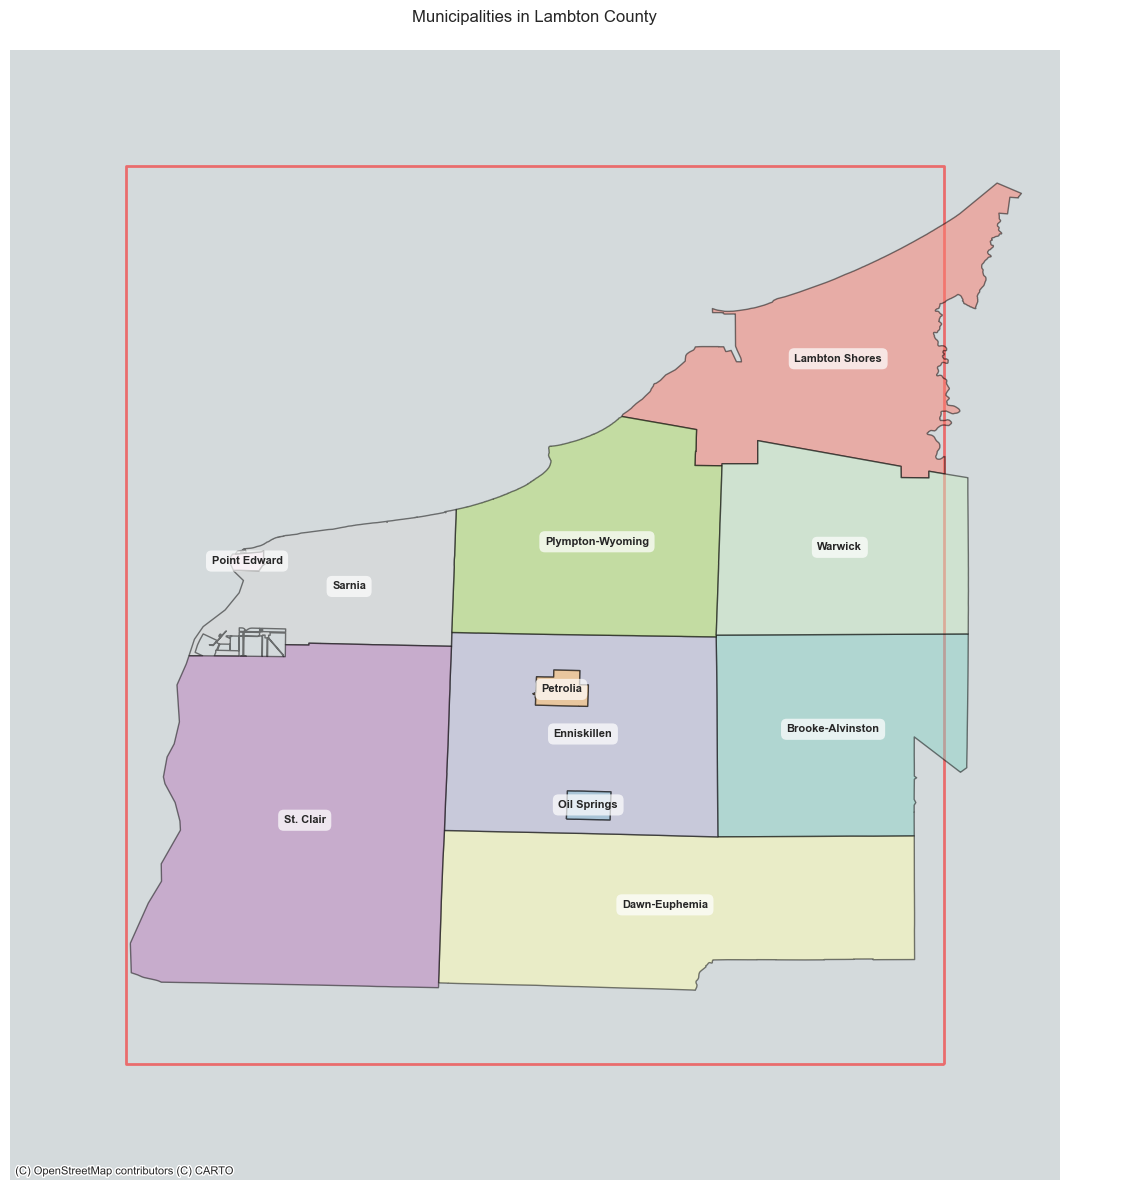

C:\Users\user\AppData\Local\Temp\ipykernel_17404\1161574521.py:173: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lambton_gdf['LANDAREA'] = lambton_gdf.geometry.area / 1e6  # Convert to square km



3. ANALYZING ALL CENSUS TRACTS

Processing tract 1 of 11

Analyzing tract 0
----------------
1. Downloading street network...
   ✓ Found 155 nodes and 444 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Found 3 features
 Successfully processed 3 features
  - Fetching shops... Found 2 features
 Successfully processed 2 features
  - Fetching education... Found 4 features
 Successfully processed 4 features
  - Fetching healthcare... Error: No data elements in server response. Check log and query location/tags.
  - Fetching recreation... Found 13 features
 Successfully processed 13 features
  - Fetching parks... Found 4 features
 Successfully processed 4 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 12 features
 Successfully processed 12 features
  - Fetching agriculture... Found 1 features
 Successfully processed 1 features
  - Fetching tourism... Found 2 featur

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")
C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Found 1 features
 Successfully processed 1 features
  - Fetching healthcare... None found
  - Fetching recreation... Found 14 features
 Successfully processed 14 features
  - Fetching parks...

C:\Users\user\anaconda3\Lib\site-packages\osmnx\features.py:1053: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  gdf = gdf.dropna(axis="columns", how="all")


 Found 5 features
 Successfully processed 5 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 5 features
 Successfully processed 5 features
  - Fetching agriculture... Error: No data elements in server response. Check log and query location/tags.
  - Fetching tourism... Found 1 features
 Successfully processed 1 features

✓ Analysis complete for tract 2

Processing tract 4 of 11

Analyzing tract 3
----------------
1. Downloading street network...
   ✓ Found 1074 nodes and 2904 edges

2. Fetching amenities and POIs...
  - Fetching restaurants... Found 20 features
 Successfully processed 20 features
  - Fetching shops... Found 16 features
 Successfully processed 16 features
  - Fetching education... Found 10 features
 Successfully processed 10 features
  - Fetching healthcare... Found 8 features
 Successfully processed 8 features
  - Fetching recreation... Found 52 features
 Successfull

  - Fetching education... Found 3 features
 Successfully processed 3 features
  - Fetching healthcare... Error: No data elements in server response. Check log and query location/tags.
  - Fetching recreation... Found 17 features
 Successfully processed 17 features
  - Fetching parks... Found 4 features
 Successfully processed 4 features
  - Fetching public_transport... Error: No data elements in server response. Check log and query location/tags.
  - Fetching community... Found 11 features
 Successfully processed 11 features
  - Fetching agriculture... Found 4 features
 Successfully processed 4 features
  - Fetching tourism... Found 2 features
 Successfully processed 2 features

✓ Analysis complete for tract 10

✓ Analysis complete for all tracts

✓ Saved complete dataset with 1337 locations to 'lambton_county_locations.csv'

Sample of location data:
                       name     category tract_id   latitude  longitude  \
0       The Alvinston Grill  restaurants        0  42.820458 -

In [3]:
def create_summary_report(lambton_tracts_with_metrics, locations_df):
    """
    Create a summary report of the analysis for Lambton County using both tract metrics and location data
    """
    print("\n5. GENERATING SUMMARY REPORT")
    print("============================")
    
    try:
        # Calculate counts by category
        category_counts = locations_df['category'].value_counts()
        
        # Calculate densities
        total_area = lambton_tracts_with_metrics['area_km2'].sum()
        
        summary = {
            'Total Amenities': len(locations_df),
            'Total Restaurants': category_counts.get('restaurants', 0),
            'Total Shops': category_counts.get('shops', 0),
            'Total Educational Facilities': category_counts.get('education', 0),
            'Total Healthcare Facilities': category_counts.get('healthcare', 0),
            'Total Parks & Nature Areas': category_counts.get('parks', 0),
            'Total Community Centers': category_counts.get('community', 0),
            'Total Agricultural Sites': category_counts.get('agriculture', 0),
            'Total Tourism Facilities': category_counts.get('tourism', 0),
            'Total Road Length (km)': lambton_tracts_with_metrics['total_edge_length_km'].sum(),
            'Average Edge Density': lambton_tracts_with_metrics['edge_density_km'].mean(),
            'Total Area (km²)': total_area,
            'Overall Amenity Density (per km²)': len(locations_df) / total_area if total_area > 0 else 0
        }
        
        print("\nLambton County Summary Statistics:")
        print("-" * 50)
        for key, value in summary.items():
            print(f"{key}: {value:.2f}")
            
        return pd.Series(summary)
        
    except Exception as e:
        print(f"\n✗ Error generating summary report: {str(e)}")
        return None
    
def visualize_amenities(lambton_tracts_with_metrics, locations_df):
    """
    Create a single visualization of all amenities in Lambton County with colored dots
    and clearly visible street layout using folium
    """
    print("\nCREATING VISUALIZATION")
    print("=====================")
    
    try:
        # Calculate center of Lambton County
        center_lat = locations_df['latitude'].mean()
        center_lon = locations_df['longitude'].mean()
        
        # Create a folium map centered on Lambton County
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=10,  # Reduced zoom level to show more area
            tiles='cartodbpositron'
        )
        
        # Define colors for each category
        category_colors = {
            'shops': '#4285F4',        # Blue
            'recreation': '#34A853',    # Green
            'community': '#9334E6',     # Purple
            'restaurants': '#EA4335',   # Red
            'education': '#FBBC05',     # Yellow/Gold
            'healthcare': '#8B0000',    # Dark Red
            'parks': '#90EE90',         # Light Green
            'public_transport': '#48D1CC', # Turquoise
            'agriculture': '#8B4513',    # Brown
            'tourism': '#FF69B4'         # Pink
        }
        
        # Add census tracts to the map
        folium.GeoJson(
            lambton_tracts_with_metrics,
            style_function=lambda x: {
                'fillColor': 'white',
                'fillOpacity': 0.1,
                'color': 'gray',
                'weight': 0.5
            },
            tooltip=folium.GeoJsonTooltip(
                fields=['CTUID'],
                aliases=['Census Tract:'],
                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
            )
        ).add_to(m)
        
        # Create feature groups for each category
        feature_groups = {category: folium.FeatureGroup(name=f"{category.title()} ({len(locations_df[locations_df['category'] == category])})") 
                        for category in category_colors.keys()}
        
        # Add points to respective feature groups
        for idx, row in locations_df.iterrows():
            color = category_colors.get(row['category'], '#808080')  # Default gray for unknown categories
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=6,
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.8,
                weight=1,
                popup=folium.Popup(
                    f"<b>{row.get('name', 'Unnamed')}</b><br>"
                    f"Type: {row.get('type_description', 'Unknown')}<br>"
                    f"Category: {row.get('category', 'Unknown')}",
                    max_width=200
                )
            ).add_to(feature_groups[row['category']])
        
        # Add all feature groups to map
        for group in feature_groups.values():
            group.add_to(m)
        
        # Add layer control
        folium.LayerControl().add_to(m)
        
        # Save the map
        m.save('lambton_county_amenities.html')
        print("Map saved as 'lambton_county_amenities.html'")
        
        return m
        
    except Exception as e:
        print(f"Error creating visualization: {str(e)}")
        raise

def run_analysis():
    """
    Main function to run the complete Lambton County analysis
    """
    print("\nLAMBTON COUNTY CENSUS TRACT ANALYSIS")
    print("====================================")
    
    try:
        # Download and prepare data
        shapefile_path = download_census_tracts()
        lambton_tracts = get_lambton_tracts(shapefile_path)
        
        # Analyze features
        lambton_tracts_with_metrics = analyze_all_tracts(lambton_tracts)
        
        if lambton_tracts_with_metrics is None:
            print("\n✗ Analysis failed - no metrics to visualize")
            return None, None
            
        # Load the locations data
        try:
            locations_df = pd.read_csv('lambton_county_locations.csv')
            print(f"\nLoaded {len(locations_df)} locations from data file")
            
            # Create visualizations
            visualize_amenities(lambton_tracts_with_metrics, locations_df)
            
            # Generate summary
            create_summary_report(lambton_tracts_with_metrics, locations_df)
            
        except Exception as e:
            print(f"\n✗ Error loading locations data: {str(e)}")
        
        return lambton_tracts_with_metrics, locations_df
        
    except Exception as e:
        print(f"\n✗ Error in main execution: {str(e)}")
        return None, None

if __name__ == "__main__":
    lambton_tracts_with_metrics, locations_df = run_analysis()

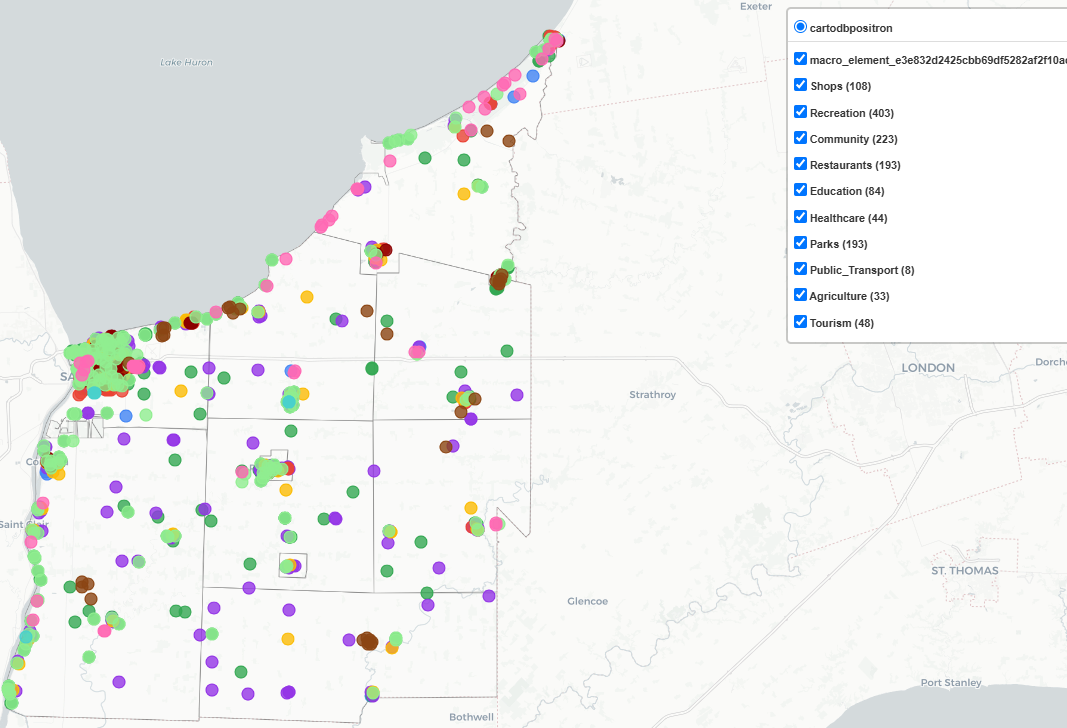